# Direct Access ABoVE UAVSAR dataset and Calculate Soil Volumetric Water Content

In this tutorial, we will read the Active Layer Thickness from Airborne L- and P- band SAR dataset (https://doi.org/10.3334/ORNLDAAC/2004) from NASA Earthdata Cloud.

In [1]:
import earthaccess
import s3fs
import xarray as xr
import numpy as np

## Authentication
We recommend authenticating your Earthdata Login (EDL) information using the `earthaccess` python library as follows:

In [2]:
# works if the EDL login already been persisted to a netrc
try:
    auth = earthaccess.login(strategy="netrc")
except FileNotFoundError:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

## Search granules

In [3]:
doi = '10.3334/ORNLDAAC/2004' # uavsar data
granules = earthaccess.search_data(
    granule_name = f"*.nc4", # retrieve only netcdfs
    cloud_hosted=True, # make sure dataset is in cloud for direct access
    doi=doi
)
print(f'Granules found: {len(granules)}')

Granules found: 51


## S3 FileSystem

In [4]:
fs = earthaccess.get_s3_filesystem(results=granules)

## Reading the first granule

In [5]:
s3_url = granules[0].data_links(access='direct')[0]
ds = xr.open_dataset(fs.open(s3_url, 'rb'), engine='h5netcdf', chunks={})
ds

<xarray.Dataset>
Dimensions:  (x: 2827, y: 2959)
Coordinates:
  * x        (x) float64 -1.358e+06 -1.358e+06 ... -1.273e+06 -1.273e+06
  * y        (y) float64 2.556e+06 2.556e+06 2.556e+06 ... 2.467e+06 2.467e+06
    lat      (y, x) float64 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
Data variables: (12/14)
    crs      |S1 ...
    alt      (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    alt_unc  (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    sub      (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    sub_unc  (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    Sw0      (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    ...       ...
    wtd_unc  (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    mv_6cm   (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    mv_12cm  (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    mv_20cm  (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    mv_alt   (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
    qa       (y, x) float32 dask.array<chunksize=(2959, 2827), meta=np.ndarray>
Attributes:
    title:            Active Layer Thickness Derived from Airborne L- and P-b...
    source:           The Airborne InSAR and PolSAR Permafrost Dynamics Obser...
    project:          Arctic-Boreal Vulnerability Experiment (ABoVE)
    Conventions:      CF-1.6
    summary:          This data file provides estimates of seasonal subsidenc...
    references:       Chen et al. 2018 https://doi.org/10.1109/IGARSS.2018.85...
    publisher_name:   Oak Ridge National Laboratory (ORNL) Distributed Active...
    publisher_url:    https://daac.ornl.gov
    publisher_email:  uso@daac.ornl.gov
    citation:         Chen, R.H., R.J. Michaelides, J. Chen, A.C. Chen, L.K. ...

## Plots of selected variables

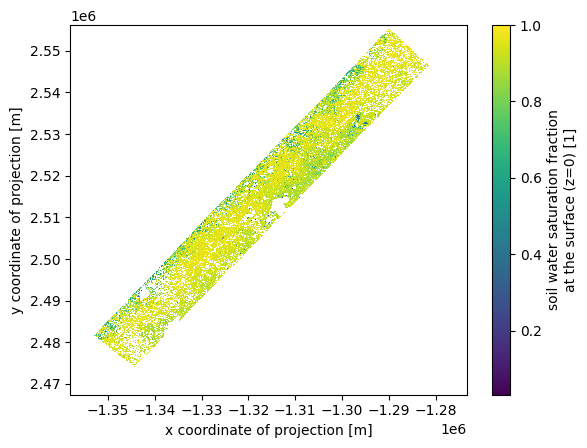

In [6]:
ds.Sw0.plot()

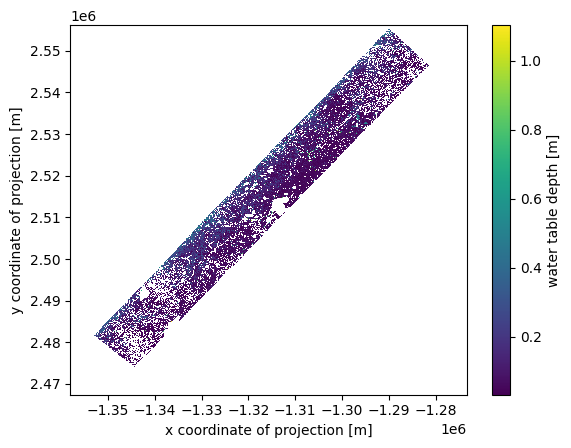

In [7]:
ds.wtd.plot()

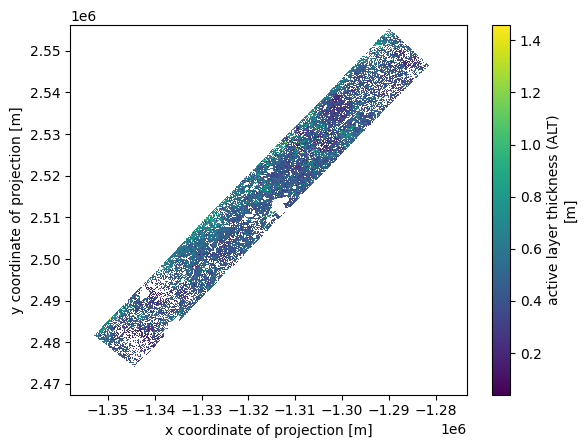

In [8]:
ds.alt.plot()

## Calculate soil volumetric water content (VWC)
The calculation is based on [this code](https://daac.ornl.gov/daacdata/above/ABoVE_ReSALT_InSAR_PolSAR_V3/data/generate_pdo_soil_vwc.py) provided with the dataset. For this tutorial, let's compute the VWC at 0.3m soil depth.

In [9]:
davg = 0.3

Let's instantiate porosity profile at various soil depths assuming a 15-cm surface organic layer.

In [10]:
# soil depths upto 1.5m at 0.01m interval
depth = np.arange(0, 1.51, 0.01)
# porosity at depths
poros = np.zeros(depth.shape)
poros[0:60] = [0.898544856, 0.898499062, 0.898423619, 0.898299395,
               0.898095018, 0.897759235, 0.897208803, 0.896309857,
               0.894850646, 0.892505296, 0.888794675, 0.883063585,
               0.874497473, 0.862106338, 0.844293206, 0.817876684,
               0.779170531, 0.729407351, 0.676689093, 0.629853558,
               0.593348919, 0.567343140, 0.549886512, 0.538609107,
               0.531497790, 0.527080555, 0.524362119, 0.522698640,
               0.521684243, 0.521066965, 0.520691823, 0.520464014,
               0.520325740, 0.520241835, 0.520190930, 0.520160050,
               0.520141318, 0.520129956, 0.520123065, 0.520118885,
               0.520116349, 0.520114812, 0.520113879, 0.520113313,
               0.520112970, 0.520112762, 0.520112636, 0.520112559,
               0.520112513, 0.520112484, 0.520112467, 0.520112457,
               0.520112451, 0.520112447, 0.520112445, 0.520112443,
               0.520112442, 0.520112442, 0.520112441, 0.520112441]
poros[60:] = 0.520112441

Now, compute soil volumetric water content averaged to depth `davg` (0.3m) and plot.

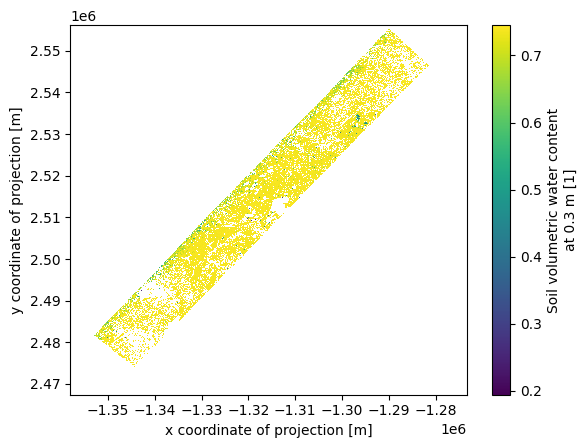

In [11]:
x = ds.x.values
y = ds.y.values
alt = ds.alt.values
Sw0 = ds.Sw0.values
wtd = ds.wtd.values
mv_avg = np.where((np.isnan(wtd) | (alt < davg)), np.nan, 0)
for idx, z in enumerate(depth):
    if z < davg:
        Sw = np.where(wtd > z, ((Sw0 - 1) / wtd**2) * (z - wtd)**2 + 1, 1)
        mv = Sw * poros[idx]
        mv_avg = mv_avg + mv * 0.01
    else:
        break
mv_avg = mv_avg / davg
ds = ds.assign(mv_avg = ds.Sw0)
ds.mv_avg[:] = np.nan
ds.mv_avg[:] = mv_avg
ds.mv_avg.attrs['long_name'] = f'Soil volumetric water content at {davg} m'
ds.mv_avg.plot()